## McCall Job Search model

Code based on Sargent and Stachursky (2023) - https://github.com/QuantEcon/book-dp1

In [1]:
using Pkg
Pkg.activate("..") ## because we have environment files in the parent directory
Pkg.instantiate() ## to download all missing packages


  Activating project at `c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code`


In [2]:
# load some packages we will need today
using Distributions, Plots

In [3]:
# create our model -- this function returns a tuple that holds all the model parameters

function create_job_search_model(;
    n=100, # wage grid size
    w_min=10.0, # lowest wage
    w_max=60.0, # highest wage
    a=200, # wage distribution parameter
    b=100, # wage distribution parameter
    β=0.96, # discount factor
    c=10.0 # unemployment compensation
    )
    w_vals = collect(LinRange(w_min, w_max, n+1))
    ϕ = pdf(BetaBinomial(n, a, b))
    az = 1
    return (; n, w_vals, ϕ, β, c)
end

create_job_search_model (generic function with 1 method)

In [4]:
my_model = create_job_search_model()

(n = 100, w_vals = [10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 12.999999999999998, 13.5, 14.0, 14.5  …  55.5, 56.0, 56.50000000000001, 57.0, 57.5, 57.99999999999999, 58.49999999999999, 59.0, 59.5, 60.0], ϕ = [2.6926666555219795e-38, 2.7061976437404457e-36, 1.3598643159794337e-34, 4.554970219819194e-33, 1.144029573959952e-31, 2.2979154027107177e-30, 3.8446651604634903e-29, 5.510591870261692e-28, 6.906536724894986e-27, 7.688393645584383e-26  …  2.631846609577836e-7, 6.937204378507532e-8, 1.628510644979505e-8, 3.352143047825189e-9, 5.928000337206458e-10, 8.757812998176919e-11, 1.0378591322031445e-11, 9.251025278040894e-13, 5.5141624819612896e-14, 1.6487345821063941e-15], β = 0.96, c = 10.0)

### Approach I
Find the continuation value $h^*$ directly. 

In [ ]:
get_h_new(h_old ;n, w_vals, ϕ, β, c) = c + β * sum(ϕ[i] * max(h_old,w_vals[i]/(1-β)) for i in 1:n)
wrap_h_new(h_old) = get_h_new(h_old; my_model...)

h_vec = LinRange(0, 2500, 100)
plot(h_vec,wrap_h_new.(h_vec), label="h_new(h_old)",linewidth=4,xlabel = "h_old",ylabel = "h_new")
plot!(h_vec,h_vec, label="45 degree line", linestyle=:dash,linewidth=2)

In [ ]:
function get_h_1(model;tol=1e-8,maxiter=1000,h_init=model.c/(1-model.β)) # do it by hand
    
    (; n, w_vals, ϕ, β, c) = model # unpack the model parameters

    h_old = Float64(h_init)
    h_new = h_old
    h_history = [h_old]
    error = tol + 1.0 
    iter = 1

    while error > tol && iter < maxiter
        h_new = get_h_new(h_old ;n, w_vals, ϕ, β, c) 
        error = abs(h_new - h_old) # think about this error criterion... why is it not great?
        h_old = h_new
        push!(h_history,h_old)
        iter += 1
    end

    return h_new, iter, error, h_history
end

In [ ]:
h, iter, error, h_history = get_h_1(my_model)

In [ ]:
function get_v_from_h(model,h) 
    
    (; n, w_vals, ϕ, β, c) = model # unpack the model parameters
    σ = w_vals ./ (1-β) .>= h # this is a vector of booleans
    v = σ .* w_vals ./ (1-β) + (1 .- σ) .* h # this is a vector of floats
    return v, σ 
end

In [ ]:
v, σ = get_v_from_h(my_model,h)

In [ ]:
plot_v = plot(my_model.w_vals,v, label="v(w)",linewidth=4,xlabel = "w",ylabel = "v")
plot_σ = plot(my_model.w_vals,σ, label="policy: 1 = accept wage",xlabel = "w", linestyle=:dash,linewidth=2)

plot(plot_v,plot_σ,layout=(1,2),legend=:topleft)

In [ ]:
reservation_wage = my_model.w_vals[σ][1]

In [ ]:
# study how reservation wage depends on unemployment compensation
c_vec = LinRange(0, 60, 100)
reservation_wage_vec = []
for c in c_vec
    my_model = create_job_search_model(;c=c)
    h, iter, error, h_history = get_h_1(my_model)
    v, σ = get_v_from_h(my_model,h)
    push!(reservation_wage_vec,my_model.w_vals[σ][1])
end

In [ ]:
plot_reservation_wage = plot(c_vec,reservation_wage_vec, label=false,linewidth=4,xlabel = "unemp. compensation",ylabel = "reservation wage")

### Approach II
Dynamic programming

In [6]:
function T(v,model) # Bellman operator
    (; n, w_vals, ϕ, β, c) = model # unpack the model parameters
    return [max(w/(1-β) , c+β * v'ϕ) for w in w_vals]
end

function get_policy(v,model) # this will be used after finding the fixed point of T
    (; n, w_vals, ϕ, β, c) = model # unpack the model parameters
    return σ = [w/(1-β) >= c+β * v'ϕ for w in w_vals]
end

function vfi(model;maxiter=1000,tol=1e-8) # value function iteration
    (; n, w_vals, ϕ, β, c) = model
    v_init = w_vals/(1-β); error = tol + 1.0; iter = 1 #  initialize
    v = v_init
    v_history = [v_init]
    while error > tol && iter < maxiter
        v_new = T(v,model)
        error = maximum(abs.(v_new - v)) 
        push!(v_history,v_new)
        v = v_new
        iter += 1
    end
    σ = get_policy(v, model)

    return v, σ, iter, error, v_history
end

vfi (generic function with 1 method)

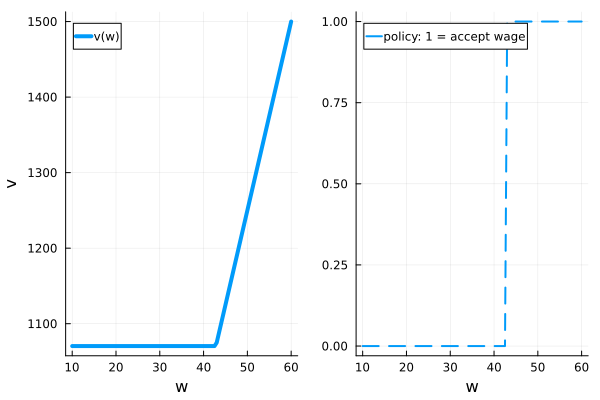

In [7]:
my_model = create_job_search_model()
v, σ, iter, error, v_history = vfi(my_model)
plot_v = plot(my_model.w_vals,v, label="v(w)",linewidth=4,xlabel = "w",ylabel = "v")
plot_σ = plot(my_model.w_vals,σ, label="policy: 1 = accept wage",xlabel = "w", linestyle=:dash,linewidth=2)
plot(plot_v,plot_σ,layout=(1,2),legend=:topleft)

┌ Info: Saved animation to c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code\DynamicProgramming\v_history.gif
└ @ Plots C:\Users\piotr\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\piotr\\Dropbox\\WNE\\QuantEcon_all\\QEcon2023\\Code\\DynamicProgramming\\v_history.gif")
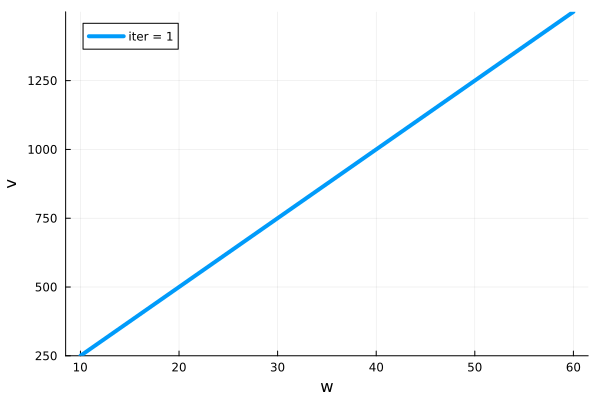

In [8]:
anim = @animate for i in 1:length(v_history)
    plot(my_model.w_vals, v_history[i], label="iter = $i", linewidth=4, xlabel="w", ylabel="v",ylim=(1-my_model.β)^(-1).*[minimum(my_model.w_vals), maximum(my_model.w_vals)])
end

gif(anim, "v_history.gif", fps = 5)
